Lab02-2
======

###  Context
#### Regression(Linear Regression)
   + Feature selection(Step wise linear regression)
   + Decision Tree Regression 

## 데이터 살펴보기

+ 이번 실습에서는 scikit-learn에서 제공하는 예제 데이터 중 하나인 당뇨병 환자 데이터를 사용합니다.
<br>데이터를 살펴보기 쉽게 csv 파일을 pandas DataFrame으로 읽습니다.

In [1]:
from os.path import join
import numpy as np

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import r2_score
from sklearn.tree import export_graphviz

import matplotlib.pyplot as plt
import seaborn as sns    

from scipy import stats

import pandas as pd
from pandas.plotting import scatter_matrix

In [2]:
df = pd.read_csv(join('data','diabetesDataset.csv'))
print(df.shape)

(442, 11)


In [3]:
df.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


##  \* 회귀 분석은 단순히 회귀식을 추정하는 것만을 의미하지 않습니다.

+ 추정된 회귀식이 정말로 종속 변수와 독립 변수간 변랑을 잘 설명할 수 있는지, 추정된 회귀 계수가 정말로 의미 있는 값인지에 대한 검정을 해야 합니다.

### \- 추정된 회귀 계수가 정말로 의미 있는 값인가?

+ 지금까지는 독립 변수들끼리 모두 독립임을 가정한 상태로 분석을 진행하였습니다.


+ 하지만 만약 두 변수가 서로에게 영향을 주고 있다면 문제가 발생합니다.


    예를 들어 학업 성취도를 종속 변수 Y로 놓고 이를 설명해주는 독립 변수 X1은 일평균 음주량을 또다른 독립 변수 X2는 혈중 알코올 농도라고 하겠습니다. 이때 일평균 음주량이나 혈중 알코올 농도가 높을수록 학업 성취도가 낮아질 것으로 추측할 수 있습니다.
    하지만 일평균 음주량과 혈중 알코올 농도는 서로 완전히 독립적이지 않습니다.
    이런 상태에서 두 변수를 사용하여 회귀 분석을 하였을 경우 변수들 각각의 설명력은 약해지게 됩니다.
    
### \- 다중 공선성 (multicollinearity)
+ 독립 변수의 일부가 다른 독립 변수의 조합으로 표현될 수 있는 경우를 말합니다.
<br>(회귀 분석에서 사용된 모형의 일부 독립 변수가 다른 독립 변수와 상관 정도가 높아, 데이터 분석 시 부정적인 영향을 미치는 현상)

## 다중 공선성 문제
+ 독립 변수와 종속 변수 간에 유의한 관계가 존재하는 경우에도 계수가 유의하지 않은 것으로 보일 수 있습니다

+ 높은 상관 관계가 있는 독립 변수에 대한 계수는 표본에 따라 크게 달라질 수 있습니다.

+ 높은 상관 관계가 있는 독립 변수 항을 제거하면 높은 상관 관계가 있는 다른 독립 변수 항의 추정 계수에 크게 영향을 미칩니다.

## 이를 방지하는 방법
+ 변수 선택법(Feature Selection)으로 의존적인 변수 삭제하는 방법
+ PCA(principal component analysis) 방법으로 의존적인 성분 삭제하는 방법
+ 정규화(regularized) 방법


> 이번 시간에는 다른 독립변수에 의존하는 변수를 없애는 방법에 대해 실습하고 이를 바탕으로 독립변수를 선택하는 실습을 하겠습니다.

## 상관계수를 통한 1차적 진단 
### : 학습과는 독립적인 과정으로 변수를 선택할 수 있습니다.

corr() 메서드는 모든 특성 간의 상관계수(피어슨의 표준 상관계수)를 행렬로 줍니다. 

\- 상관관계의 범위는 -1부터 1까지 입니다.

\- 1에 가까우면 강한 양의 상관관계, -1에 가까우면 강한 음의 상관관계를 가진다는 뜻입니다.


\- 상관계수가 0에 가까우면 선형적인 상관관계가 없다는 뜻입니다.


$-1.0 <= r <= -0.7$ : 매우 강한 음(-)의 상관 관계

$-0.7 <  r <= -0.3$ : 강한 음(-)의 상관 관계

$-0.3 <  r <= -0.1$ : 약한 음(-)의 상관 관계

$-0.1 <  r <=  0.1$ : 상관 관계 없음

$ 0.1 <  r <=  0.3$ : 약한 양(+)의 상관 관계

$ 0.3 <  r <=  0.7$ : 강한 양(+)의 상관 관계

$ 0.7 <  r <=  1.0$ : 매우 강한 양(+)의 상관 관계


1) Dataframe

In [4]:
df.corr()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,y
age,1.000000,0.173737,0.185085,0.335427,0.260061,0.219243,-0.075181,0.203841,0.270777,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241013,0.035277,0.142637,-0.379090,0.332115,0.149918,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395415,0.249777,0.261170,-0.366811,0.413807,0.446159,0.388680,0.586450
map,0.335427,0.241013,0.395415,1.000000,0.242470,0.185558,-0.178761,0.257653,0.393478,0.390429,0.441484
tc,0.260061,0.035277,0.249777,0.242470,1.000000,0.896663,0.051519,0.542207,0.515501,0.325717,0.212022
ldl,0.219243,0.142637,0.261170,0.185558,0.896663,1.000000,-0.196455,0.659817,0.318353,0.290600,0.174054
hdl,-0.075181,-0.379090,-0.366811,-0.178761,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
tch,0.203841,0.332115,0.413807,0.257653,0.542207,0.659817,-0.738493,1.000000,0.617857,0.417212,0.430453
ltg,0.270777,0.149918,0.446159,0.393478,0.515501,0.318353,-0.398577,0.617857,1.000000,0.464670,0.565883
glu,0.301731,0.208133,0.388680,0.390429,0.325717,0.290600,-0.273697,0.417212,0.464670,1.000000,0.382483


In [5]:
dfx = df.iloc[:,:-1]
dfy = df.iloc[:,-1]
# df = pd.concat([dfx,dfy],axis = 1)

2) scatter matrix

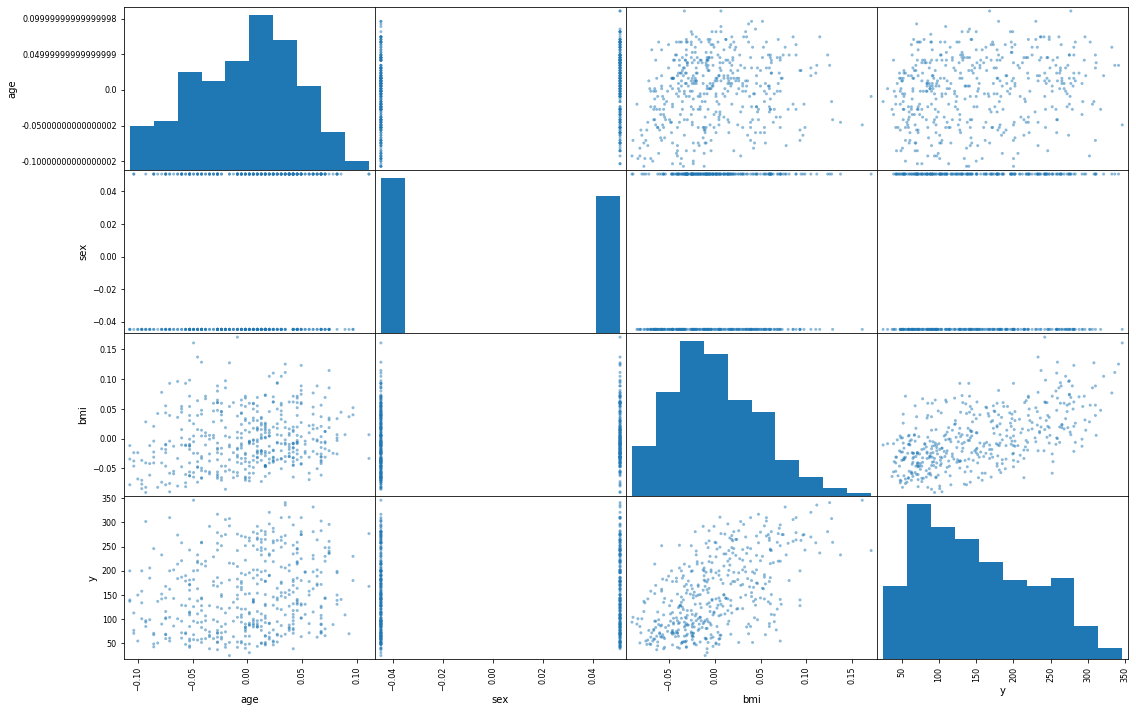

In [6]:
dfx1 = df.loc[:,'age':'bmi']
dfx2 = df.loc[:,'map':'ldl']
dfx3 = df.loc[:,'hdl':'glu']

dfy = df.loc[:,'y']

df1 = pd.concat([dfx1,dfy], axis = 1)
df2 = pd.concat([dfx2,dfy], axis = 1)
df3 = pd.concat([dfx3,dfy], axis = 1)


scatter_matrix(df1, figsize = (18,12))
plt.show()

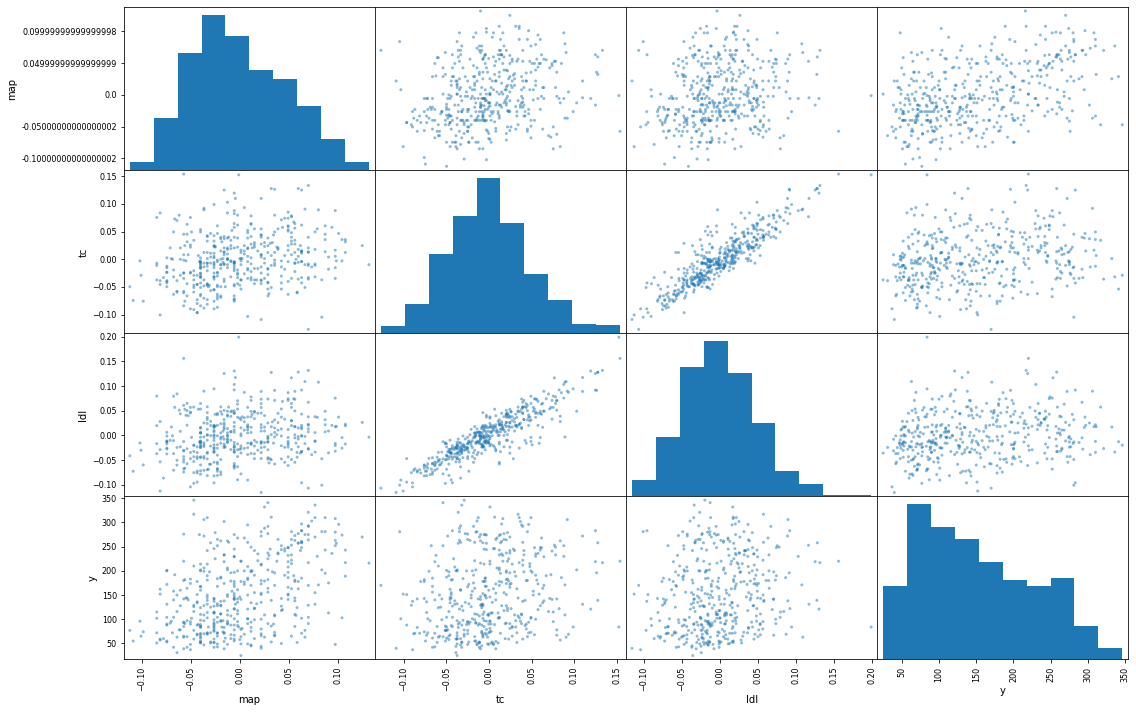

In [7]:
scatter_matrix(df2, figsize = (18,12))
plt.show()

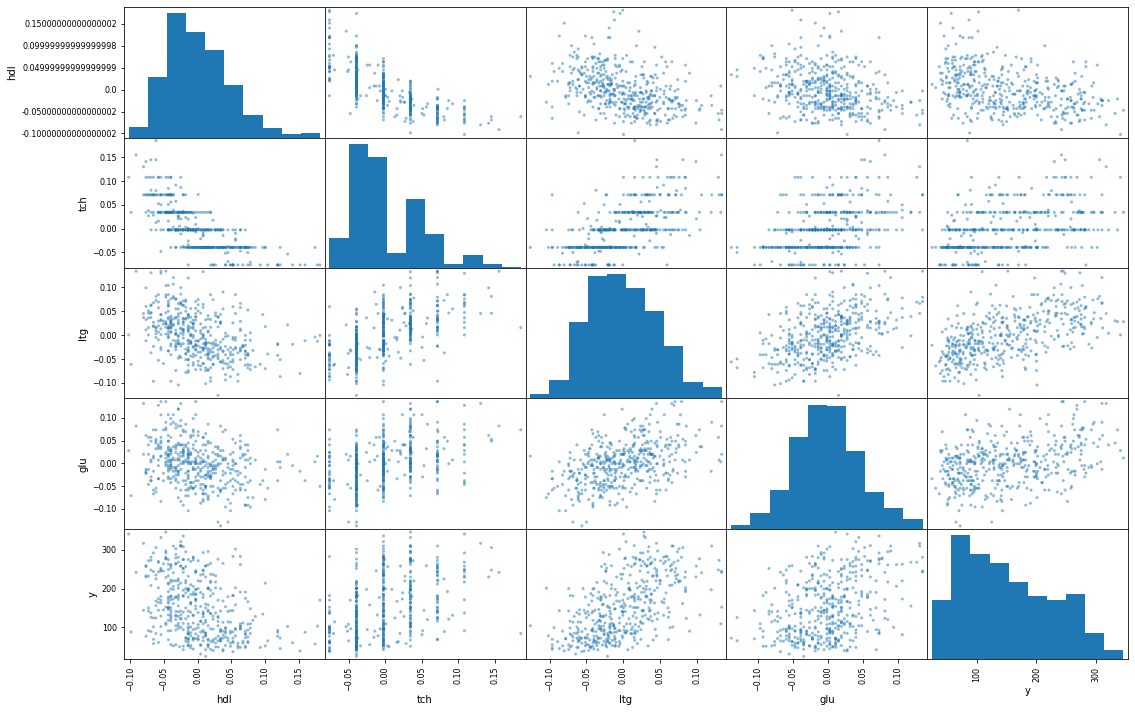

In [8]:
scatter_matrix(df3, figsize = (18,12))
plt.show()

3) heatmap

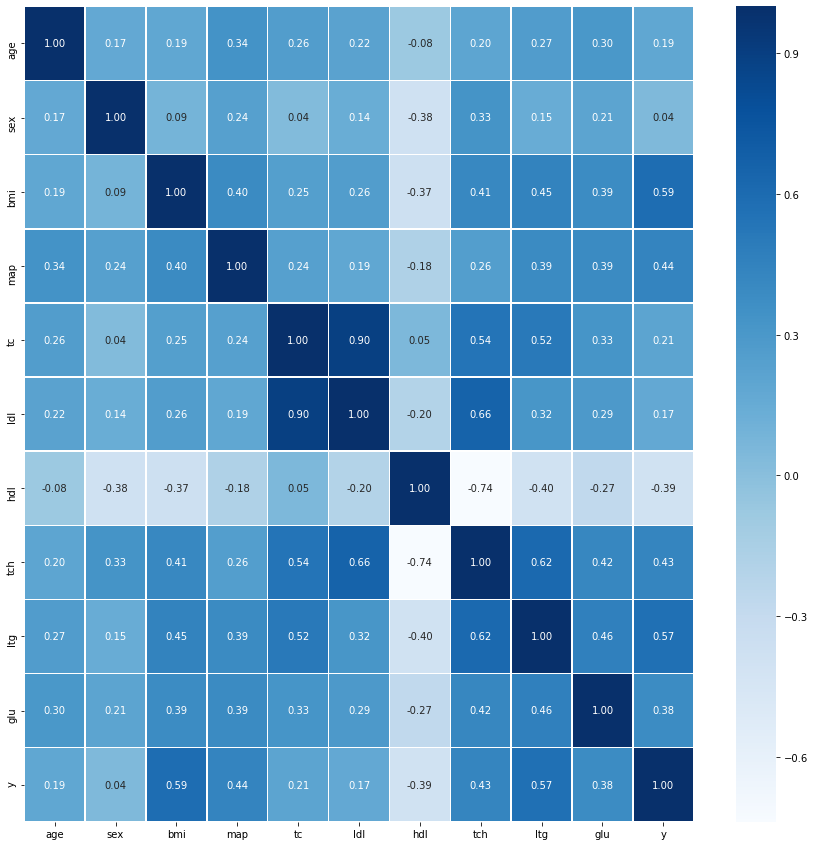

In [9]:
plt.figure(figsize=(15,15))
sns.heatmap(data=df.corr(), 
            annot=True, # 각 셀의 값 표시 여부 
            fmt ='.2f', # 각 셀에 값 표시할 경우 데이터 형식
            linewidths=.5, cmap='Blues')
plt.show()

### 1) 데이터 살펴보기

In [10]:
dfx = df.iloc[:,:-1]
dfy = df[['y']]
label = dfx.columns
print(label)
print(dfx.shape)
dfx.head()

Index(['age', 'sex', 'bmi', 'map', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu'], dtype='object')
(442, 10)


,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


이번에는 성능평가를 위해 데이터를 나눠보겠습니다.

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.2, random_state=2019)

### 2) 회귀식 추정하기

모든 독립변수를 선택하여 회귀식 추정 

In [12]:
# 선형회귀 추정기 생성
lr = linear_model.LinearRegression()

# input 대해 선형 회귀(모델 파라미터 추정)
lr.fit(x_train, y_train)

y_pred_all = lr.predict(x_test)

상관관계가 높은 ldl과 tc를 각각 제외한 독립변수로 회귀식 추정

    tc 제외한 모든 독립변수 선택

In [13]:
x_train_except_tc = x_train.loc[:,x_train.columns!='tc']

In [14]:
x_train_except_tc.head()

,age,sex,bmi,map,ldl,hdl,tch,ltg,glu
163,0.016281,0.050680,0.072474,0.076958,0.005575,-0.006584,-0.002592,-0.023645,0.061054
27,-0.023677,-0.044642,0.059541,-0.040099,-0.043589,0.011824,-0.039493,-0.015998,0.040343
207,0.009016,-0.044642,0.045529,0.028758,-0.013840,0.026550,-0.039493,0.046132,0.036201
266,-0.052738,0.050680,-0.062252,0.011544,-0.036700,0.122273,-0.076395,-0.086829,0.003064
320,-0.023677,-0.044642,0.030440,-0.005671,0.092004,-0.017629,0.071210,0.033047,0.003064


In [15]:
x_test_except_tc = x_test.loc[:,x_test.columns!='tc']

In [16]:
x_test_except_tc.head()

,age,sex,bmi,map,ldl,hdl,tch,ltg,glu
111,0.019913,-0.044642,0.004572,-0.026328,0.010273,0.067048,-0.039493,-0.023645,-0.046641
366,-0.045472,0.050680,0.137143,-0.015999,0.031880,-0.043401,0.071210,0.071022,0.048628
112,-0.085430,-0.044642,0.020739,-0.026328,0.019667,-0.002903,-0.002592,-0.023645,0.003064
289,-0.074533,0.050680,0.055229,-0.040099,0.053174,-0.043401,0.071210,0.061238,-0.034215
339,0.027178,-0.044642,-0.007284,-0.050428,0.056619,0.033914,-0.002592,0.043443,0.015491


In [17]:
# 선형회귀 추정기 생성
lr_except_tc = linear_model.LinearRegression()

# input 대해 선형 회귀(모델 파라미터 추정)
lr_except_tc.fit(x_train_except_tc, y_train)

y_pred_except_tc = lr_except_tc.predict(x_test_except_tc)

    ldl 제외한 모든 독립변수 선택

In [18]:
x_train_except_ldl = x_train.loc[:,x_train.columns!='ldl']

In [19]:
x_train_except_ldl.head()

,age,sex,bmi,map,tc,hdl,tch,ltg,glu
163,0.016281,0.050680,0.072474,0.076958,-0.008449,-0.006584,-0.002592,-0.023645,0.061054
27,-0.023677,-0.044642,0.059541,-0.040099,-0.042848,0.011824,-0.039493,-0.015998,0.040343
207,0.009016,-0.044642,0.045529,0.028758,0.012191,0.026550,-0.039493,0.046132,0.036201
266,-0.052738,0.050680,-0.062252,0.011544,-0.008449,0.122273,-0.076395,-0.086829,0.003064
320,-0.023677,-0.044642,0.030440,-0.005671,0.082364,-0.017629,0.071210,0.033047,0.003064


In [20]:
x_test_except_ldl = x_test.loc[:,x_test.columns!='ldl']

In [21]:
x_test_except_ldl.head()

,age,sex,bmi,map,tc,hdl,tch,ltg,glu
111,0.019913,-0.044642,0.004572,-0.026328,0.023198,0.067048,-0.039493,-0.023645,-0.046641
366,-0.045472,0.050680,0.137143,-0.015999,0.041086,-0.043401,0.071210,0.071022,0.048628
112,-0.085430,-0.044642,0.020739,-0.026328,0.005311,-0.002903,-0.002592,-0.023645,0.003064
289,-0.074533,0.050680,0.055229,-0.040099,0.053469,-0.043401,0.071210,0.061238,-0.034215
339,0.027178,-0.044642,-0.007284,-0.050428,0.075484,0.033914,-0.002592,0.043443,0.015491


In [22]:
# 선형회귀 추정기 생성
lr_except_ldl = linear_model.LinearRegression()

# input 대해 선형 회귀(모델 파라미터 추정)
lr_except_ldl.fit(x_train_except_ldl, y_train)

y_pred_except_ldl = lr_except_ldl.predict(x_test_except_ldl)

### 3) 평가 비교하기

In [23]:
# R2 scroe
R2_all = r2_score(y_test, y_pred_all)
R2_except_tc = r2_score(y_test, y_pred_except_tc)
R2_except_ldl = r2_score(y_test, y_pred_except_ldl)

print('R2_all score: %.4f' % R2_all)
print('R2_except_tc score: %.4f' % R2_except_tc)
print('R2_except_ldl score: %.4f' % R2_except_ldl)

R2_all score: 0.4708
R2_except_tc score: 0.4637
R2_except_ldl score: 0.4676


In [24]:
# adj R2 score
n = len(x_test)

p = len(dfx.columns)
p_except_tc = p-1
p_except_ldl = p-1

Adj_r2_all = 1-(1-R2_all)*(n-1)/(n-p-1)
Adj_r2_except_ldl = 1-(1-R2_except_tc)*(n-1)/(n-p_except_tc-1)
Adj_r2_except_tc = 1-(1-R2_except_ldl)*(n-1)/(n-p_except_ldl-1)
print('Adj R2_all score: %.4f' % Adj_r2_all)
print('Adj R2_except_ldl score: %.4f' % Adj_r2_except_ldl)
print('Adj R2_except_tc score: %.4f' % Adj_r2_except_tc)

Adj R2_all score: 0.4029
Adj R2_except_ldl score: 0.4026
Adj R2_except_tc score: 0.4070


### 4) PCA 맛보기

마지막 날 차원 축소 수업에서 자세히 다룰 예정입니다.
간단히 말해 여러 차원으로 이뤄진 데이터에 대해서 가장 잘 표현하는 새로운 축을 찾아 이 축으로 사영시켜 차원을 축소하는 방법입니다.

In [25]:
x_train_temp = x_train[['tc','ldl']]
x_test_temp = x_test[['tc','ldl']]

In [26]:
x_train_temp.head()

,tc,ldl
163,-0.008449,0.005575
27,-0.042848,-0.043589
207,0.012191,-0.013840
266,-0.008449,-0.036700
320,0.082364,0.092004


In [27]:
x_test_temp.head()

,tc,ldl
111,0.023198,0.010273
366,0.041086,0.031880
112,0.005311,0.019667
289,0.053469,0.053174
339,0.075484,0.056619


In [28]:
from sklearn.decomposition import PCA

In [29]:
# PCA 모델에 축소하고자 하는 차원을 n_compoenets 값에 넣어 생성합니다.
pca = PCA(n_components=1)
# X데이터에 대해 주성분을 뽑아내야하니 X데이터 전체를 넣습니다.
pca.fit(x_train_temp)
pca.fit(x_test_temp)
# 이제 PCA 모델이 X데이터의 주성분을 찾아냈습니다. 찾은 2개의 주성분에 X데이터를 Projection 합니다.
pca_X_train = pca.transform(x_train_temp)
pca_X_test = pca.transform(x_test_temp)

In [30]:
pca_X_train = pd.DataFrame(pca_X_train, columns=['pca'], index=x_train.index)

In [31]:
pca_X_test = pd.DataFrame(pca_X_test, columns=['pca'], index=x_test.index)

In [32]:
pca_X_train.head()

,pca
163,0.008234
27,0.067649
207,0.008353
266,0.039147
320,-0.116911


In [33]:
pca_X_test.head()

,pca
111,-0.016788
366,-0.044789
112,-0.011456
289,-0.068807
339,-0.086343


tc, ldl 열을 제외한 열을 선택하고 pca열을 새로운 열로 추가

In [34]:
x_train_except_ldl_tc = x_train_except_ldl.loc[:,x_train_except_ldl.columns!='tc']

In [35]:
x_train_pca=pd.concat([pca_X_train, x_train_except_ldl_tc], axis=1)

In [36]:
x_train_pca.head()

,pca,age,sex,bmi,map,hdl,tch,ltg,glu
163,0.008234,0.016281,0.050680,0.072474,0.076958,-0.006584,-0.002592,-0.023645,0.061054
27,0.067649,-0.023677,-0.044642,0.059541,-0.040099,0.011824,-0.039493,-0.015998,0.040343
207,0.008353,0.009016,-0.044642,0.045529,0.028758,0.026550,-0.039493,0.046132,0.036201
266,0.039147,-0.052738,0.050680,-0.062252,0.011544,0.122273,-0.076395,-0.086829,0.003064
320,-0.116911,-0.023677,-0.044642,0.030440,-0.005671,-0.017629,0.071210,0.033047,0.003064


In [37]:
x_test_except_ldl_tc = x_test_except_ldl.loc[:,x_test_except_ldl.columns!='tc']

In [38]:
x_test_pca=pd.concat([pca_X_test, x_test_except_ldl_tc], axis=1)

In [39]:
x_test_pca.head()

,pca,age,sex,bmi,map,hdl,tch,ltg,glu
111,-0.016788,0.019913,-0.044642,0.004572,-0.026328,0.067048,-0.039493,-0.023645,-0.046641
366,-0.044789,-0.045472,0.050680,0.137143,-0.015999,-0.043401,0.071210,0.071022,0.048628
112,-0.011456,-0.085430,-0.044642,0.020739,-0.026328,-0.002903,-0.002592,-0.023645,0.003064
289,-0.068807,-0.074533,0.050680,0.055229,-0.040099,-0.043401,0.071210,0.061238,-0.034215
339,-0.086343,0.027178,-0.044642,-0.007284,-0.050428,0.033914,-0.002592,0.043443,0.015491


In [40]:
# 선형회귀 추정기 생성
lr_pca = linear_model.LinearRegression()

# input 대해 선형 회귀(모델 파라미터 추정)
lr_pca.fit(x_train_pca, y_train)

y_pred_pca = lr_pca.predict(x_test_pca)

In [41]:
R2_pca = r2_score(y_test, y_pred_pca)
print('R2_pca score: %.4f' % R2_pca)

R2_pca score: 0.4654


In [42]:
# adj R2 score
n = len(x_test)

p_pca = p-1

Adj_r2_pca = 1-(1-R2_pca)*(n-1)/(n-p_pca-1)

print('Adj R2_all score: %.4f' % Adj_r2_pca)

Adj R2_all score: 0.4045


- 산점도 행렬이나 상관관계수를 계한하여 상관 관계가 높은 독립변수들을 판단하고 다중공선성 문제가 일어날 것이라는 예상을 할 수 있습니다만 아닙니다.

- 상관관계는 인과관계를 의미하진 않습니다.
<br>:x와 y가 강한 상관관계를 보인다면 x가 y를 발생시켰다고 볼 수도 있고, y가 x를 발생시켰다고 볼 수도 있습니다. 혹은 서로 동시에 발생시키거나, 다른 외부 요인이 발생시키거나 아니면 아무런 인과관계도 없을 수 있습니다.

### \*시각적으로 독립변수 간의 상관 관계를 추측할 수 있으나, 관계 정도가 유의한지 알아 볼 필요가 있습니다.
### - 유의성 검정

# Stepwise Linear Regression

## Feature selection 

-  변수 선택법(Feature Selection)으로 의존적인 변수 삭제하는 방법


+ 전방 탐색(Forward Search)
    1. 0개 변수에서 시작합니다.
    2. 한번에 하나의 변수에 대해서 시도합니다.
    3. 회귀 모델을 만들고 각 변수의 기여도를 측정합니다.
    4. 가장 높은 기여도를 가진 변수를 추가합니다.
    5. 선택하지 않은 변수 중에 통계적으로 중요한 변수가 남지 않을 때 까지 반복합니다.
    
    
+ 후방 소거(Backward Eliminate)
    1. 모든 변수를 가지고 시작합니다.
    2. 한번에 하나의 변수에 대해서 제거를 시도합니다.
    3. 회귀 모델을 만들고 각 변수의 기여도를 측정합니다.
    4. 가장 낮은 기여도를 가진 변수를 삭제합니다.
    5. 통계적으로 중요하게 제거할 변수가 남지 않을 때 까지 반복합니다.
    
    
+ 단계적 선택(Stepwise Selection)
    <br>전방 탐색 + 후방 소거
    <br>전방 탐색과 비슷하게 변수를 추가합니다.
    <br>단계에 상관 없이 가장 중요하지 않은 변수를 제거하도록 합니다.

## p-value 분석을 통한 변수 선택(Feature Selection)
+ 가설 검정을 통해서 판단합니다.
    + 귀무가설을 회귀 계수 = 0이라고 설정(회귀 계수가 유의미 하지 않다.)
    + 그 회귀 계수가 유의미하다고 판단하면 기각


+ 다중공선성이 생기면 해당 변수의 설명력은 약해집니다.
+ 이는 변수의 표준오차의 증가로 드러납니다.
+ 검정 통계량 = (추정된 회귀 계수 - H0) / 그 계수의 추정 표준 오차

        1) 여기서 표준 오차는 표본의 실제관측치가 표본 회귀선상의 추정치에서 얼마나 흩어져 있나를 측정한 값입니다.

        2) 표준오차가 작으면 작을수록 실제값과 추정값간의 차이가 없다고 볼수 있습니다.

        3) 표준오차 구하기 
<center>$s = \sqrt{\sum \frac{(Y_i-\hat{Y})^2}{n-2}}$

        (추정표준오차의 제곱은 잔차의 분산입니다.)


+ 이 검정 통계량의 절대값이 클수록 p-value는 작아져서(표준 오차가 커졌기 때문) 귀무가설을 기각할 수 있게 됩니다.





![stepwise2](./Images/stepwise_2.png)

ex) Y = 2(X1) + 3(X2) <다중 공선성 문제가 있는 X1, X2>

=> X1이 설명력 있는 독립 변수라면 p-value가 유의 수준보다 작아 유의한 통계량이 됩니다.

(문제 발생)그런데, X2가 설명할 부분을 X1이 가져가 버렸기 때문에 X2의 설명력은 작아지게 됩니다.

### 1) 데이터 살펴보기

In [43]:
# 컬럼이름으로 다중 컬럼 선택 (return DatFrame)
## 하나의 컬럼을 선택할 경우 Series를 반환
## 하나의 컬럼을 DataFrame으로 반환하기 위해서는 컬럼 리스트로 입력

diabetes_X = df.iloc[:,:-1]
diabetes_Y = df[['y']]

In [44]:
print(diabetes_X.shape)
diabetes_X.head()

(442, 10)


,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [45]:
diabetes_Y.head()

,y
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0


### 2-1) 회귀식 추정위해 변수 선택하기

In [46]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in= 0.15, 
                       threshold_out = 0.1, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        print('\nforward step')
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            lm = linear_model.LinearRegression()
            included_X =  pd.DataFrame(X[included+[new_column]])
            lm.fit(included_X,y)
            params = np.append(lm.intercept_,lm.coef_)
            predictions = lm.predict(included_X)
            
            newX = pd.DataFrame({"Constant":np.ones(len(included_X))}).join(pd.DataFrame(included_X))

            MSE = (sum((y.values-predictions)**2))/(len(newX)-len(newX.columns))
         
            var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
            

            sd_b = np.sqrt(var_b)
            ts_b = params/ sd_b
            p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

            new_pval[new_column] = p_values[-1]

        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            print('best_feature: {}' .format(best_feature))
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        
        # backward step
        print('\nbackward step')
        lm = linear_model.LinearRegression()
        included_X = X[included]
        lm.fit(included_X,y)
        params = np.append(lm.intercept_,lm.coef_)

        predictions = lm.predict(included_X)
        newX = pd.DataFrame({"Constant":np.ones(len(included_X))}).join(pd.DataFrame(included_X))
        MSE = (sum((y.values-predictions)**2))/(len(newX)-len(newX.columns))
        var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
        sd_b = np.sqrt(var_b)
        ts_b = params/ sd_b

        p_values = 2*(1-stats.t.cdf(np.abs(ts_b),(len(newX)-1)))

        # use all coefs except intercept
        pvalues = p_values[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            print('worst_feature: {}' .format(worst_feature))
            included.remove(included[worst_feature])
            print('included: {}' .format(included))
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [47]:
diabetes_Y.head()

,y
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0


In [48]:
diabetes_X.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [49]:
result = stepwise_selection(diabetes_X, diabetes_Y)

print('resulting features:')
print(result)

newlabel = result


forward step
best_feature: ltg
Add  ltg                            with p-value 0.0

backward step

forward step
best_feature: bmi
Add  bmi                            with p-value 0.0

backward step

forward step
best_feature: map
Add  map                            with p-value 3.73729e-05

backward step

forward step
best_feature: tc
Add  tc                             with p-value 0.00145345

backward step

forward step
best_feature: sex
Add  sex                            with p-value 0.00922566

backward step

forward step
best_feature: ldl
Add  ldl                            with p-value 0.000271839

backward step

forward step

backward step
resulting features:
['ltg', 'bmi', 'map', 'tc', 'sex', 'ldl']


In [50]:
result = stepwise_selection(diabetes_X, diabetes_Y)

print('resulting features:')
print(result)

newlabel = result


forward step
best_feature: ltg
Add  ltg                            with p-value 0.0

backward step

forward step
best_feature: bmi
Add  bmi                            with p-value 0.0

backward step

forward step
best_feature: map
Add  map                            with p-value 3.73729e-05

backward step

forward step
best_feature: tc
Add  tc                             with p-value 0.00145345

backward step

forward step
best_feature: sex
Add  sex                            with p-value 0.00922566

backward step

forward step
best_feature: ldl
Add  ldl                            with p-value 0.000271839

backward step

forward step

backward step
resulting features:
['ltg', 'bmi', 'map', 'tc', 'sex', 'ldl']


### 2-2) 선택된 변수로 회귀식 추정하기

In [51]:
diabetes_X_multi = df[newlabel]
diabetes_Y_multi = df[['y']]

# 선형회귀 추정기 생성
lr = linear_model.LinearRegression() 

# input 대해 선형 회귀(모델 파라미터 추정)
lr.fit(diabetes_X_multi, diabetes_Y_multi)

# 회귀식으로 데이터의 결과 추정
diabetes_y_pred_multi = lr.predict(diabetes_X_multi)

### 3) 평가하기

In [52]:
# R2 scroe
R2 = r2_score(diabetes_Y_multi, diabetes_y_pred_multi)
print('R2 score: %.2f' % R2)

# adj R2 score
n = len(diabetes_X_multi)
p = len(newlabel)

Adj_r2 = 1-(1-R2)*(n-1)/(n-p-1)
print('Adj R2 score: %.3f' % Adj_r2)

R2 score: 0.51
Adj R2 score: 0.508


### 4) 모든 독립변수에 대해 조사해본다면?

In [53]:
import itertools

newlabel = ['age', 'sex', 'bmi', 'map', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']
combs = []
adj_list = []
for i in range(1, len(newlabel)+1):
    els = [list(x) for x in itertools.combinations(newlabel, i)]
    combs.extend(els) # list 원소만을 append(일반적인 append는 list 자체를 추가한다.)
for i in range(len(combs)):
    print('label', combs[i])

    dfx = df[combs[i]]
    dfy = df[['y']]
    print(dfx.shape)

    # 선형회귀 추정기 생성
    lr2 = linear_model.LinearRegression()

    # input 대해 선형 회귀(모델 파라미터 추정)
    lr2.fit(dfx, dfy)

    # 모델 파라미터 출력
    print('Model parameters: \n')
    rgstr = ''
    for i in range(len(lr2.coef_[0])):
        print("b%d" %(len(lr2.coef_[0])-i),": ", "%f" %lr2.coef_[0,i])
        rgstr = ' + '+repr(lr2.coef_[0,i]) + '*x'+repr(len(lr2.coef_[0])-i) + rgstr

    print('b0:', lr2.intercept_[0])
    print()
    rgstr = repr(lr2.intercept_[0]) + rgstr
    print('y = ', rgstr)

    y_pred = lr2.predict(dfx)
    n = len(dfx)
    p = len(combs[i])

    R2 = r2_score(dfy, y_pred)
    Adj_r2 = 1-(1-R2)*(n-1)/(n-p-1)
    adj_list.append(Adj_r2)
    print('R2 score: %.3f' %  R2)
    print('Adj R2 score: %.3f' %  Adj_r2)
    print('**************************************************************')

label ['age']
(442, 1)
Model parameters: 

b1 :  304.183079
b0: 152.13348420418777

y =  152.13348420418777 + 304.18307891359785*x1
R2 score: 0.035
Adj R2 score: 0.033
**************************************************************
label ['sex']
(442, 1)
Model parameters: 

b1 :  69.715352
b0: 152.13348425122308

y =  152.13348425122308 + 69.71535220207838*x1
R2 score: 0.002
Adj R2 score: -0.000
**************************************************************
label ['bmi']
(442, 1)
Model parameters: 

b1 :  949.435260
b0: 152.13348401253288

y =  152.13348401253288 + 949.4352597978527*x1
R2 score: 0.344
Adj R2 score: 0.342
**************************************************************
label ['map']
(442, 1)
Model parameters: 

b1 :  714.741649
b0: 152.1334843246022

y =  152.1334843246022 + 714.7416488773438*x1
R2 score: 0.195
Adj R2 score: 0.193
**************************************************************
label ['tc']
(442, 1)
Model parameters: 

b1 :  343.254450
b0: 152.13348415513

y

(442, 2)
Model parameters: 

b2 :  558.044424
b1 :  401.345883
b0: 152.13348433455144

y =  152.13348433455144 + 401.3458829566027*x1 + 558.0444239449396*x2
R2 score: 0.247
Adj R2 score: 0.245
**************************************************************
label ['tc', 'ldl']
(442, 2)
Model parameters: 

b2 :  462.197484
b1 :  -132.650772
b0: 152.13348413443208

y =  152.13348413443208 + -132.6507724271757*x1 + 462.1974843420848*x2
R2 score: 0.046
Adj R2 score: 0.044
**************************************************************
label ['tc', 'hdl']
(442, 2)
Model parameters: 

b2 :  377.183949
b1 :  -658.577555
b0: 152.13348410966253

y =  152.13348410966253 + -658.577555367756*x1 + 377.183948974851*x2
R2 score: 0.210
Adj R2 score: 0.208
**************************************************************
label ['tc', 'tch']
(442, 2)
Model parameters: 

b2 :  -49.008570
b1 :  723.455850
b0: 152.13348295278905

y =  152.13348295278905 + 723.4558495828215*x1 + -49.0085695981603*x2
R2 score: 0.1

(442, 3)
Model parameters: 

b3 :  67.216221
b2 :  829.514476
b1 :  276.525918
b0: 152.13348407193047

y =  152.13348407193047 + 276.52591755333356*x1 + 829.5144756602162*x2 + 67.21622128365932*x3
R2 score: 0.374
Adj R2 score: 0.372
**************************************************************
label ['age', 'map', 'tc']
(442, 3)
Model parameters: 

b3 :  37.686043
b2 :  660.053899
b1 :  173.410712
b0: 152.13348431342183

y =  152.13348431342183 + 173.4107115923158*x1 + 660.0538988095714*x2 + 37.686043035158114*x3
R2 score: 0.207
Adj R2 score: 0.205
**************************************************************
label ['age', 'map', 'ldl']
(442, 3)
Model parameters: 

b3 :  46.622026
b2 :  671.845518
b1 :  146.896841
b0: 152.1334843411667

y =  152.1334843411667 + 146.89684070995*x1 + 671.8455183471659*x2 + 46.622025524893694*x3
R2 score: 0.204
Adj R2 score: 0.203
**************************************************************
label ['age', 'map', 'hdl']
(442, 3)
Model parameters: 

b3 :


b3 :  -83.925283
b2 :  677.298970
b1 :  626.537813
b0: 152.13348406270123

y =  152.13348406270123 + 626.5378128149312*x1 + 677.298969906144*x2 + -83.92528340678906*x3
R2 score: 0.462
Adj R2 score: 0.461
**************************************************************
label ['sex', 'bmi', 'glu']
(442, 3)
Model parameters: 

b3 :  -68.188341
b2 :  835.466831
b1 :  308.685833
b0: 152.13348397910895

y =  152.13348397910895 + 308.68583321908363*x1 + 835.4668314153607*x2 + -68.18834069011844*x3
R2 score: 0.374
Adj R2 score: 0.372
**************************************************************
label ['sex', 'map', 'tc']
(442, 3)
Model parameters: 

b3 :  -104.493897
b2 :  696.767501
b1 :  177.995651
b0: 152.13348418411815

y =  152.13348418411815 + 177.9956510839371*x1 + 696.767501131577*x2 + -104.49389746175058*x3
R2 score: 0.211
Adj R2 score: 0.209
**************************************************************
label ['sex', 'map', 'ldl']
(442, 3)
Model parameters: 

b3 :  -126.260321
b2 :  

R2 score: 0.388
Adj R2 score: 0.387
**************************************************************
label ['bmi', 'tc', 'ltg']
(442, 3)
Model parameters: 

b3 :  679.861965
b2 :  -194.025540
b1 :  712.832749
b0: 152.13348418863472

y =  152.13348418863472 + 712.8327493393335*x1 + -194.02553968777238*x2 + 679.8619652823637*x3
R2 score: 0.470
Adj R2 score: 0.469
**************************************************************
label ['bmi', 'tc', 'glu']
(442, 3)
Model parameters: 

b3 :  828.469468
b2 :  44.203770
b1 :  282.815401
b0: 152.13348406268298

y =  152.13348406268298 + 282.8154008761095*x1 + 44.20376979936435*x2 + 828.46946776687*x3
R2 score: 0.373
Adj R2 score: 0.371
**************************************************************
label ['bmi', 'ldl', 'hdl']
(442, 3)
Model parameters: 

b3 :  826.150626
b2 :  -0.010900
b1 :  -336.106296
b0: 152.1334840092435

y =  152.1334840092435 + -336.1062958622602*x1 + -0.010899535675719108*x2 + 826.1506262060631*x3
R2 score: 0.381
Adj R2 scor


b3 :  1610.627345
b2 :  -1356.628762
b1 :  -988.640444
b0: 152.13348387519636

y =  152.13348387519636 + -988.640443801744*x1 + -1356.6287622568245*x2 + 1610.6273447278459*x3
R2 score: 0.306
Adj R2 score: 0.305
**************************************************************
label ['tc', 'ldl', 'tch']
(442, 3)
Model parameters: 

b3 :  705.984780
b2 :  -989.104524
b1 :  966.720834
b0: 152.13348239416396

y =  152.13348239416396 + 966.7208339122583*x1 + -989.1045240529868*x2 + 705.9847803459564*x3
R2 score: 0.243
Adj R2 score: 0.241
**************************************************************
label ['tc', 'ldl', 'ltg']
(442, 3)
Model parameters: 

b3 :  -882.299778
b2 :  708.237894
b1 :  1145.494997
b0: 152.13348448632777

y =  152.13348448632777 + 1145.4949965102946*x1 + 708.2378940940819*x2 + -882.2997781706396*x3
R2 score: 0.361
Adj R2 score: 0.360
**************************************************************
label ['tc', 'ldl', 'glu']
(442, 3)
Model parameters: 

b3 :  273.591243


(442, 4)
Model parameters: 

b4 :  26.281735
b3 :  -87.461107
b2 :  675.283790
b1 :  620.850501
b0: 152.1334840610789

y =  152.1334840610789 + 620.8505007884496*x1 + 675.2837903314767*x2 + -87.46110680440893*x3 + 26.281735042870043*x4
R2 score: 0.462
Adj R2 score: 0.461
**************************************************************
label ['age', 'sex', 'bmi', 'glu']
(442, 4)
Model parameters: 

b4 :  76.624226
b3 :  -77.027802
b2 :  829.422133
b1 :  289.755168
b0: 152.13348397712693

y =  152.13348397712693 + 289.7551675535767*x1 + 829.4221325657437*x2 + -77.02780194628718*x3 + 76.62422567983258*x4
R2 score: 0.376
Adj R2 score: 0.374
**************************************************************
label ['age', 'sex', 'map', 'tc']
(442, 4)
Model parameters: 

b4 :  50.188215
b3 :  -109.681134
b2 :  683.525022
b1 :  168.337552
b0: 152.13348418158142

y =  152.13348418158142 + 168.33755205279317*x1 + 683.5250222021339*x2 + -109.68113367321325*x3 + 50.188215253019244*x4
R2 score: 0.211
Adj


b4 :  -10.205889
b3 :  670.306700
b2 :  368.987713
b1 :  326.515151
b0: 152.13348359218043

y =  152.13348359218043 + 326.51515058806297*x1 + 368.98771255105765*x2 + 670.3067000202368*x3 + -10.205889009401538*x4
R2 score: 0.429
Adj R2 score: 0.428
**************************************************************
label ['age', 'bmi', 'map', 'ltg']
(442, 4)
Model parameters: 

b4 :  -49.358676
b3 :  603.388558
b2 :  275.559982
b1 :  551.870065
b0: 152.13348422286626

y =  152.13348422286626 + 551.8700646030591*x1 + 275.55998235895134*x2 + 603.3885579258034*x3 + -49.358675598115816*x4
R2 score: 0.481
Adj R2 score: 0.480
**************************************************************
label ['age', 'bmi', 'map', 'glu']
(442, 4)
Model parameters: 

b4 :  -9.325640
b3 :  735.454990
b2 :  349.005714
b1 :  199.917929
b0: 152.13348414673095

y =  152.13348414673095 + 199.91792874367502*x1 + 349.0057139911342*x2 + 735.4549898668113*x3 + -9.325640380284277*x4
R2 score: 0.408
Adj R2 score: 0.406
*****


b4 :  -34.679937
b3 :  513.810515
b2 :  475.279835
b1 :  230.787613
b0: 152.1334835048248

y =  152.1334835048248 + 230.78761271984894*x1 + 475.27983519070517*x2 + 513.8105147350528*x3 + -34.679937432833995*x4
R2 score: 0.317
Adj R2 score: 0.315
**************************************************************
label ['age', 'map', 'ltg', 'glu']
(442, 4)
Model parameters: 

b4 :  -67.694994
b3 :  399.090250
b2 :  704.790717
b1 :  156.336519
b0: 152.13348438924754

y =  152.13348438924754 + 156.3365189264618*x1 + 704.7907168015468*x2 + 399.09024955262544*x3 + -67.69499424086591*x4
R2 score: 0.384
Adj R2 score: 0.383
**************************************************************
label ['age', 'tc', 'ldl', 'hdl']
(442, 4)
Model parameters: 

b4 :  118.459888
b3 :  1551.365863
b2 :  -1325.928421
b1 :  -970.650160
b0: 152.13348389800618

y =  152.13348389800618 + -970.6501604017157*x1 + -1325.9284210344501*x2 + 1551.3658626105098*x3 + 118.45988810479432*x4
R2 score: 0.311
Adj R2 score: 0.310
*


b4 :  -104.154968
b3 :  786.843277
b2 :  426.487205
b1 :  12.003143
b0: 152.1334840044414

y =  152.1334840044414 + 12.003143457766214*x1 + 426.4872049976159*x2 + 786.8432766109377*x3 + -104.15496798981104*x4
R2 score: 0.400
Adj R2 score: 0.398
**************************************************************
label ['sex', 'bmi', 'map', 'hdl']
(442, 4)
Model parameters: 

b4 :  -253.996554
b3 :  640.670641
b2 :  447.469249
b1 :  -420.437571
b0: 152.13348381232757

y =  152.13348381232757 + -420.4375713440021*x1 + 447.4692489606292*x2 + 640.6706413585378*x3 + -253.99655393162453*x4
R2 score: 0.450
Adj R2 score: 0.449
**************************************************************
label ['sex', 'bmi', 'map', 'tch']
(442, 4)
Model parameters: 

b4 :  -218.092944
b3 :  641.410094
b2 :  411.145215
b1 :  397.962321
b0: 152.1334832117458

y =  152.1334832117458 + 397.9623211233085*x1 + 411.14521481516147*x2 + 641.4100942613503*x3 + -218.09294372856783*x4
R2 score: 0.444
Adj R2 score: 0.443
*****

(442, 4)
Model parameters: 

b4 :  -352.242164
b3 :  636.743894
b2 :  -393.667537
b1 :  359.088164
b0: 152.13348323276813

y =  152.13348323276813 + 359.0881642643915*x1 + -393.667536591541*x2 + 636.7438941141273*x3 + -352.24216392307534*x4
R2 score: 0.356
Adj R2 score: 0.354
**************************************************************
label ['sex', 'map', 'hdl', 'ltg']
(442, 4)
Model parameters: 

b4 :  -296.183025
b3 :  471.895060
b2 :  -425.884256
b1 :  605.113710
b0: 152.13348397502168

y =  152.13348397502168 + 605.1137104455856*x1 + -425.8842562320483*x2 + 471.8950600620624*x3 + -296.1830246709776*x4
R2 score: 0.436
Adj R2 score: 0.435
**************************************************************
label ['sex', 'map', 'hdl', 'glu']
(442, 4)
Model parameters: 

b4 :  -355.475799
b3 :  575.268472
b2 :  -586.764879
b1 :  308.011470
b0: 152.13348383768786

y =  152.13348383768786 + 308.01146996454105*x1 + -586.764878563854*x2 + 575.2684723438703*x3 + -355.4757986555668*x4
R2 score:

R2 score: 0.401
Adj R2 score: 0.399
**************************************************************
label ['bmi', 'map', 'tc', 'hdl']
(442, 4)
Model parameters: 

b4 :  651.446485
b3 :  370.191281
b2 :  108.273113
b1 :  -339.589874
b0: 152.13348411798066

y =  152.13348411798066 + -339.5898741464218*x1 + 108.2731130221872*x2 + 370.1912810828125*x3 + 651.4464854130374*x4
R2 score: 0.434
Adj R2 score: 0.433
**************************************************************
label ['bmi', 'map', 'tc', 'tch']
(442, 4)
Model parameters: 

b4 :  669.015625
b3 :  380.435036
b2 :  -128.462366
b1 :  391.672818
b0: 152.1334834901791

y =  152.1334834901791 + 391.6728183241909*x1 + -128.4623656948471*x2 + 380.43503626410984*x3 + 669.0156246837666*x4
R2 score: 0.433
Adj R2 score: 0.432
**************************************************************
label ['bmi', 'map', 'tc', 'ltg']
(442, 4)
Model parameters: 

b4 :  605.706587
b3 :  271.281189
b2 :  -206.669986
b1 :  645.692819
b0: 152.13348424988865

y 

(442, 4)
Model parameters: 

b4 :  636.874325
b3 :  -266.030874
b2 :  -142.480112
b1 :  613.990342
b0: 152.13348439364793

y =  152.13348439364793 + 613.9903424855761*x1 + -142.48011221789545*x2 + -266.03087418824555*x3 + 636.8743251777315*x4
R2 score: 0.472
Adj R2 score: 0.471
**************************************************************
label ['bmi', 'hdl', 'tch', 'glu']
(442, 4)
Model parameters: 

b4 :  727.277049
b3 :  -192.233373
b2 :  164.067064
b1 :  215.480258
b0: 152.13348378436197

y =  152.13348378436197 + 215.48025804371667*x1 + 164.06706393041173*x2 + -192.23337296774065*x3 + 727.2770493556808*x4
R2 score: 0.405
Adj R2 score: 0.404
**************************************************************
label ['bmi', 'hdl', 'ltg', 'glu']
(442, 4)
Model parameters: 

b4 :  613.672735
b3 :  -178.957673
b2 :  531.672256
b1 :  84.667882
b0: 152.1334841593696

y =  152.1334841593696 + 84.66788237119127*x1 + 531.6722559688815*x2 + -178.9576733229257*x3 + 613.672735453131*x4
R2 score: 0.

R2 score: 0.390
Adj R2 score: 0.389
**************************************************************
label ['tc', 'ldl', 'hdl', 'tch']
(442, 4)
Model parameters: 

b4 :  1676.197800
b3 :  -1365.837777
b2 :  -1066.430319
b1 :  -98.311829
b0: 152.13348403177739

y =  152.13348403177739 + -98.31182852885581*x1 + -1066.4303189917637*x2 + -1365.837777202875*x3 + 1676.197800438939*x4
R2 score: 0.307
Adj R2 score: 0.305
**************************************************************
label ['tc', 'ldl', 'hdl', 'ltg']
(442, 4)
Model parameters: 

b4 :  -921.363510
b3 :  741.403102
b2 :  17.073575
b1 :  1161.879258
b0: 152.13348449583796

y =  152.13348449583796 + 1161.8792579892652*x1 + 17.07357494989494*x2 + 741.4031016021868*x3 + -921.3635103842362*x4
R2 score: 0.361
Adj R2 score: 0.360
**************************************************************
label ['tc', 'ldl', 'hdl', 'glu']
(442, 4)
Model parameters: 

b4 :  1378.715403
b3 :  -1207.599984
b2 :  -869.965850
b1 :  282.973821
b0: 152.133483

Model parameters: 

b5 :  139.889429
b4 :  -185.805895
b3 :  764.651217
b2 :  -345.396909
b1 :  641.557793
b0: 152.1334827043889

y =  152.1334827043889 + 641.5577928868174*x1 + -345.39690887101773*x2 + 764.6512165701537*x3 + -185.80589501382175*x4 + 139.88942896881107*x5
R2 score: 0.422
Adj R2 score: 0.420
**************************************************************
label ['age', 'sex', 'bmi', 'ldl', 'ltg']
(442, 5)
Model parameters: 

b5 :  38.527851
b4 :  -79.755831
b3 :  688.910126
b2 :  -99.593555
b1 :  642.005820
b0: 152.1334840606551

y =  152.1334840606551 + 642.0058199521766*x1 + -99.5935546445881*x2 + 688.9101255109451*x3 + -79.75583087988616*x4 + 38.527851419840886*x5
R2 score: 0.466
Adj R2 score: 0.464
**************************************************************
label ['age', 'sex', 'bmi', 'ldl', 'glu']
(442, 5)
Model parameters: 

b5 :  80.167356
b4 :  -75.018998
b3 :  834.113969
b2 :  -28.591911
b1 :  294.753194
b0: 152.13348397609406

y =  152.13348397609406 + 294.75

R2 score: 0.364
Adj R2 score: 0.362
**************************************************************
label ['age', 'sex', 'map', 'tch', 'ltg']
(442, 5)
Model parameters: 

b5 :  -35.324576
b4 :  -223.030937
b3 :  471.785077
b2 :  289.014797
b1 :  594.933026
b0: 152.13348360607557

y =  152.13348360607557 + 594.9330263487984*x1 + 289.01479651401405*x2 + 471.7850773850391*x3 + -223.0309368502738*x4 + -35.324575604239875*x5
R2 score: 0.403
Adj R2 score: 0.402
**************************************************************
label ['age', 'sex', 'map', 'tch', 'glu']
(442, 5)
Model parameters: 

b5 :  -15.564887
b4 :  -295.465496
b3 :  555.519279
b2 :  556.435351
b1 :  236.372805
b0: 152.13348300727114

y =  152.13348300727114 + 236.37280519104135*x1 + 556.4353507200018*x2 + 555.5192791776731*x3 + -295.46549572528386*x4 + -15.56488689702356*x5
R2 score: 0.346
Adj R2 score: 0.344
**************************************************************
label ['age', 'sex', 'map', 'ltg', 'glu']
(442, 5)
Mode


b5 :  30.973098
b4 :  -160.902228
b3 :  223.470251
b2 :  686.371660
b1 :  231.195249
b0: 152.13348373949017

y =  152.13348373949017 + 231.19524938513143*x1 + 686.3716602811937*x2 + 223.47025080427795*x3 + -160.9022278675036*x4 + 30.97309781107012*x5
R2 score: 0.353
Adj R2 score: 0.352
**************************************************************
label ['age', 'bmi', 'map', 'tc', 'ldl']
(442, 5)
Model parameters: 

b5 :  14.872129
b4 :  793.425688
b3 :  376.902485
b2 :  247.929273
b1 :  -220.941139
b0: 152.13348408892992

y =  152.13348408892992 + -220.94113868631052*x1 + 247.9292730232977*x2 + 376.9024853944288*x3 + 793.425687541028*x4 + 14.872129190087746*x5
R2 score: 0.401
Adj R2 score: 0.399
**************************************************************
label ['age', 'bmi', 'map', 'tc', 'hdl']
(442, 5)
Model parameters: 

b5 :  6.747372
b4 :  651.329619
b3 :  368.320101
b2 :  106.991186
b1 :  -339.393918
b0: 152.13348411853406

y =  152.13348411853406 + -339.3939183935282*x1 + 10

R2 score: 0.474
Adj R2 score: 0.473
**************************************************************
label ['age', 'bmi', 'ldl', 'hdl', 'glu']
(442, 5)
Model parameters: 

b5 :  84.815582
b4 :  744.703167
b3 :  -60.643820
b2 :  -306.392502
b1 :  237.944421
b0: 152.1334840543587

y =  152.1334840543587 + 237.94442068994238*x1 + -306.39250239595987*x2 + -60.643820422388956*x3 + 744.7031666508861*x4 + 84.81558216537266*x5
R2 score: 0.404
Adj R2 score: 0.403
**************************************************************
label ['age', 'bmi', 'ldl', 'tch', 'ltg']
(442, 5)
Model parameters: 

b5 :  37.235951
b4 :  665.955019
b3 :  -221.553793
b2 :  226.586350
b1 :  539.468865
b0: 152.13348375069614

y =  152.13348375069614 + 539.4688645208822*x1 + 226.58635005707015*x2 + -221.55379269658965*x3 + 665.9550189306844*x4 + 37.2359505498911*x5
R2 score: 0.471
Adj R2 score: 0.469
**************************************************************
label ['age', 'bmi', 'ldl', 'tch', 'glu']
(442, 5)
Model par

R2 score: 0.410
Adj R2 score: 0.409
**************************************************************
label ['age', 'map', 'hdl', 'tch', 'glu']
(442, 5)
Model parameters: 

b5 :  -10.999684
b4 :  507.805274
b3 :  -303.001663
b2 :  244.702403
b1 :  239.256127
b0: 152.13348387310754

y =  152.13348387310754 + 239.25612668377957*x1 + 244.70240338671175*x2 + -303.0016634381181*x3 + 507.80527449426756*x4 + -10.999683582660873*x5
R2 score: 0.333
Adj R2 score: 0.331
**************************************************************
label ['age', 'map', 'hdl', 'ltg', 'glu']
(442, 5)
Model parameters: 

b5 :  -49.086637
b4 :  395.367970
b3 :  -300.985228
b2 :  598.517107
b1 :  119.178450
b0: 152.13348434706413

y =  152.13348434706413 + 119.17845049285123*x1 + 598.5171066379861*x2 + -300.9852284019353*x3 + 395.3679697920136*x4 + -49.08663729902788*x5
R2 score: 0.413
Adj R2 score: 0.412
**************************************************************
label ['age', 'map', 'tch', 'ltg', 'glu']
(442, 5)
Mod

Model parameters: 

b5 :  -254.043474
b4 :  635.054633
b3 :  439.789043
b2 :  -187.982517
b1 :  507.077280
b0: 152.13348299525651

y =  152.13348299525651 + 507.077279868498*x1 + -187.98251658856472*x2 + 439.7890433872224*x3 + 635.054632983488*x4 + -254.0434736626529*x5
R2 score: 0.453
Adj R2 score: 0.452
**************************************************************
label ['sex', 'bmi', 'map', 'tc', 'ltg']
(442, 5)
Model parameters: 

b5 :  -148.374774
b4 :  600.633934
b3 :  305.033042
b2 :  -216.843353
b1 :  662.163774
b0: 152.13348407355338

y =  152.13348407355338 + 662.163773756973*x1 + -216.84335264007302*x2 + 305.0330419543362*x3 + 600.6339336934781*x4 + -148.37477359531803*x5
R2 score: 0.500
Adj R2 score: 0.499
**************************************************************
label ['sex', 'bmi', 'map', 'tc', 'glu']
(442, 5)
Model parameters: 

b5 :  -129.367592
b4 :  728.361494
b3 :  372.317319
b2 :  5.269483
b1 :  215.968994
b0: 152.13348399218629

y =  152.13348399218629 + 215.


b5 :  -168.088060
b4 :  781.827035
b3 :  -312.183312
b2 :  -18.360784
b1 :  621.606954
b0: 152.13348274179148

y =  152.13348274179148 + 621.606953890662*x1 + -18.360784200078456*x2 + -312.18331159184766*x3 + 781.8270347374878*x4 + -168.08806046022588*x5
R2 score: 0.415
Adj R2 score: 0.414
**************************************************************
label ['sex', 'bmi', 'ldl', 'hdl', 'ltg']
(442, 5)
Model parameters: 

b5 :  -155.196081
b4 :  634.759365
b3 :  -98.109005
b2 :  -250.161471
b1 :  587.726695
b0: 152.13348394181855

y =  152.13348394181855 + 587.7266951545648*x1 + -250.16147060498315*x2 + -98.10900483057543*x3 + 634.7593647140727*x4 + -155.19608108657988*x5
R2 score: 0.482
Adj R2 score: 0.481
**************************************************************
label ['sex', 'bmi', 'ldl', 'hdl', 'glu']
(442, 5)
Model parameters: 

b5 :  -189.921522
b4 :  728.456501
b3 :  -37.350916
b2 :  -373.475997
b1 :  284.250146
b0: 152.13348380864065

y =  152.13348380864065 + 284.25014627

(442, 5)
Model parameters: 

b5 :  -356.368424
b4 :  573.658243
b3 :  23.424688
b2 :  -584.240295
b1 :  302.709684
b0: 152.13348383894404

y =  152.13348383894404 + 302.7096842584575*x1 + -584.2402947188746*x2 + 23.424688083873548*x3 + 573.6582433012142*x4 + -356.3684242581946*x5
R2 score: 0.363
Adj R2 score: 0.362
**************************************************************
label ['sex', 'map', 'ldl', 'tch', 'ltg']
(442, 5)
Model parameters: 

b5 :  -257.128325
b4 :  485.648459
b3 :  -278.385414
b2 :  508.341790
b1 :  538.136953
b0: 152.13348315553822

y =  152.13348315553822 + 538.1369527693976*x1 + 508.34179049735064*x2 + -278.3854141344724*x3 + 485.6484591932883*x4 + -257.12832494960344*x5
R2 score: 0.419
Adj R2 score: 0.418
**************************************************************
label ['sex', 'map', 'ldl', 'tch', 'glu']
(442, 5)
Model parameters: 

b5 :  -331.621530
b4 :  562.032997
b3 :  -382.224090
b2 :  814.196876
b1 :  240.191759
b0: 152.1334824820491

y =  152.133482

(442, 5)
Model parameters: 

b5 :  -182.460516
b4 :  -244.377281
b3 :  411.659978
b2 :  648.364935
b1 :  255.189490
b0: 152.1334833555651

y =  152.1334833555651 + 255.18949040787487*x1 + 648.3649345405468*x2 + 411.65997752432014*x3 + -244.37728078662855*x4 + -182.46051563414542*x5
R2 score: 0.365
Adj R2 score: 0.364
**************************************************************
label ['sex', 'hdl', 'tch', 'ltg', 'glu']
(442, 5)
Model parameters: 

b5 :  -224.629622
b4 :  -450.911466
b3 :  -113.915873
b2 :  722.218798
b1 :  254.495800
b0: 152.13348419791882

y =  152.13348419791882 + 254.4957999889363*x1 + 722.2187978143478*x2 + -113.91587333634578*x3 + -450.9114662949212*x4 + -224.6296216987688*x5
R2 score: 0.386
Adj R2 score: 0.385
**************************************************************
label ['bmi', 'map', 'tc', 'ldl', 'hdl']
(442, 5)
Model parameters: 

b5 :  608.943480
b4 :  301.132176
b3 :  990.869522
b2 :  -938.981421
b1 :  -597.464048
b0: 152.1334839441531

y =  152.1334

R2 score: 0.479
Adj R2 score: 0.478
**************************************************************
label ['bmi', 'tc', 'hdl', 'tch', 'ltg']
(442, 5)
Model parameters: 

b5 :  647.933593
b4 :  -180.598837
b3 :  -89.177213
b2 :  61.198770
b1 :  646.800295
b0: 152.13348407292366

y =  152.13348407292366 + 646.8002953591277*x1 + 61.198770033084486*x2 + -89.17721314093913*x3 + -180.59883737262936*x4 + 647.9335928279918*x5
R2 score: 0.475
Adj R2 score: 0.474
**************************************************************
label ['bmi', 'tc', 'hdl', 'tch', 'glu']
(442, 5)
Model parameters: 

b5 :  722.728667
b4 :  50.361540
b3 :  -242.699027
b2 :  102.532014
b1 :  212.705381
b0: 152.13348388322623

y =  152.13348388322623 + 212.7053806411604*x1 + 102.53201371150854*x2 + -242.69902674098643*x3 + 50.36153990320423*x4 + 722.7286668385481*x5
R2 score: 0.405
Adj R2 score: 0.404
**************************************************************
label ['bmi', 'tc', 'hdl', 'ltg', 'glu']
(442, 5)
Model para

(442, 5)
Model parameters: 

b5 :  508.402896
b4 :  -266.724078
b3 :  -133.830027
b2 :  545.393636
b1 :  234.063769
b0: 152.13348334600417

y =  152.13348334600417 + 234.0637688719743*x1 + 545.39363551365*x2 + -133.83002702136287*x3 + -266.72407847549846*x4 + 508.4028958252305*x5
R2 score: 0.343
Adj R2 score: 0.341
**************************************************************
label ['map', 'ldl', 'hdl', 'ltg', 'glu']
(442, 5)
Model parameters: 

b5 :  386.355265
b4 :  -80.577416
b3 :  -309.258588
b2 :  608.755815
b1 :  124.280121
b0: 152.133484342619

y =  152.133484342619 + 124.28012098577675*x1 + 608.7558145162003*x2 + -309.2585878233627*x3 + -80.57741550982416*x4 + 386.3552651942953*x5
R2 score: 0.414
Adj R2 score: 0.413
**************************************************************
label ['map', 'ldl', 'tch', 'ltg', 'glu']
(442, 5)
Model parameters: 

b5 :  399.344664
b4 :  -241.596612
b3 :  356.727436
b2 :  557.034632
b1 :  125.846459
b0: 152.1334837382703

y =  152.1334837382703

R2 score: 0.459
Adj R2 score: 0.458
**************************************************************
label ['age', 'sex', 'bmi', 'map', 'tch', 'ltg']
(442, 6)
Model parameters: 

b6 :  -38.102111
b5 :  -170.618790
b4 :  571.150544
b3 :  315.150294
b2 :  144.940557
b1 :  483.653556
b0: 152.1334837672808

y =  152.1334837672808 + 483.6535563314726*x1 + 144.94055671014007*x2 + 315.15029419433534*x3 + 571.1505437317226*x4 + -170.61879037293323*x5 + -38.10211071849348*x6
R2 score: 0.491
Adj R2 score: 0.490
**************************************************************
label ['age', 'sex', 'bmi', 'map', 'tch', 'glu']
(442, 6)
Model parameters: 

b6 :  -13.321025
b5 :  -222.987965
b4 :  619.053652
b3 :  384.638803
b2 :  365.692774
b1 :  126.293880
b0: 152.13348326959198

y =  152.13348326959198 + 126.2938796132839*x1 + 365.69277361219105*x2 + 384.63880304858026*x3 + 619.0536518393316*x4 + -222.98796537253605*x5 + -13.321025473480029*x6
R2 score: 0.449
Adj R2 score: 0.447
***********************


b6 :  20.152260
b5 :  -93.283132
b4 :  664.178450
b3 :  -112.095450
b2 :  605.692650
b1 :  125.532201
b0: 152.13348405086967

y =  152.13348405086967 + 125.53220081755003*x1 + 605.6926501829184*x2 + -112.09544981650265*x3 + 664.1784497570543*x4 + -93.28313180814536*x5 + 20.152260020104308*x6
R2 score: 0.470
Adj R2 score: 0.469
**************************************************************
label ['age', 'sex', 'bmi', 'hdl', 'tch', 'ltg']
(442, 6)
Model parameters: 

b6 :  57.810313
b5 :  -166.120798
b4 :  619.700980
b3 :  -324.585792
b2 :  -124.329823
b1 :  596.350180
b0: 152.133484156191

y =  152.133484156191 + 596.350179624128*x1 + -124.32982315244894*x2 + -324.5857919663621*x3 + 619.70098043241*x4 + -166.120798365069*x5 + 57.810312650835144*x6
R2 score: 0.481
Adj R2 score: 0.480
**************************************************************
label ['age', 'sex', 'bmi', 'hdl', 'tch', 'glu']
(442, 6)
Model parameters: 

b6 :  91.141331
b5 :  -212.689680
b4 :  696.008415
b3 :  -274.582

R2 score: 0.395
Adj R2 score: 0.393
**************************************************************
label ['age', 'sex', 'map', 'hdl', 'tch', 'ltg']
(442, 6)
Model parameters: 

b6 :  4.374840
b5 :  -293.796948
b4 :  470.306709
b3 :  -451.930227
b2 :  -45.694363
b1 :  622.047646
b0: 152.1334840560783

y =  152.1334840560783 + 622.0476462174679*x1 + -45.69436340949086*x2 + -451.9302267326171*x3 + 470.3067093258919*x4 + -293.79694758787554*x5 + 4.374840341125036*x6
R2 score: 0.436
Adj R2 score: 0.435
**************************************************************
label ['age', 'sex', 'map', 'hdl', 'tch', 'glu']
(442, 6)
Model parameters: 

b6 :  21.495647
b5 :  -363.941721
b4 :  556.910590
b3 :  -417.524720
b2 :  257.516823
b1 :  249.336502
b0: 152.1334833994391

y =  152.1334833994391 + 249.3365019898676*x1 + 257.5168228745066*x2 + -417.5247196452874*x3 + 556.910589666289*x4 + -363.9417213845219*x5 + 21.495647114307726*x6
R2 score: 0.374
Adj R2 score: 0.372
*******************************

(442, 6)
Model parameters: 

b6 :  -13.048447
b5 :  746.965284
b4 :  336.588809
b3 :  211.046693
b2 :  -219.200143
b1 :  196.373519
b0: 152.13348410666202

y =  152.13348410666202 + 196.3735188118012*x1 + -219.20014254938752*x2 + 211.0466930582496*x3 + 336.58880892775414*x4 + 746.9652843957376*x5 + -13.048447050598703*x6
R2 score: 0.411
Adj R2 score: 0.410
**************************************************************
label ['age', 'bmi', 'map', 'tc', 'hdl', 'tch']
(442, 6)
Model parameters: 

b6 :  6.575483
b5 :  653.312638
b4 :  372.219928
b3 :  -6.526735
b2 :  -189.911978
b1 :  192.584110
b0: 152.13348380936722

y =  152.13348380936722 + 192.58410968676117*x1 + -189.91197782299653*x2 + -6.526735098350457*x3 + 372.21992799904785*x4 + 653.3126375156135*x5 + 6.575483447794408*x6
R2 score: 0.436
Adj R2 score: 0.434
**************************************************************
label ['age', 'bmi', 'map', 'tc', 'hdl', 'ltg']
(442, 6)
Model parameters: 

b6 :  -23.447005
b5 :  569.946770


R2 score: 0.477
Adj R2 score: 0.476
**************************************************************
label ['age', 'bmi', 'tc', 'ldl', 'tch', 'glu']
(442, 6)
Model parameters: 

b6 :  51.902117
b5 :  726.321990
b4 :  481.586897
b3 :  -771.539595
b2 :  570.954720
b1 :  150.395070
b0: 152.13348300039956

y =  152.13348300039956 + 150.3950701963223*x1 + 570.9547199185765*x2 + -771.5395951416178*x3 + 481.58689714787045*x4 + 726.3219897476164*x5 + 51.9021171386762*x6
R2 score: 0.437
Adj R2 score: 0.435
**************************************************************
label ['age', 'bmi', 'tc', 'ldl', 'ltg', 'glu']
(442, 6)
Model parameters: 

b6 :  21.508325
b5 :  617.800455
b4 :  -513.824774
b3 :  306.953678
b2 :  755.504518
b1 :  99.706268
b0: 152.13348426928872

y =  152.13348426928872 + 99.70626772499293*x1 + 755.5045177796387*x2 + 306.9536779216339*x3 + -513.8247738859864*x4 + 617.8004552004534*x5 + 21.508325082016107*x6
R2 score: 0.480
Adj R2 score: 0.478
**********************************

R2 score: 0.413
Adj R2 score: 0.411
**************************************************************
label ['age', 'map', 'ldl', 'hdl', 'tch', 'ltg']
(442, 6)
Model parameters: 

b6 :  -23.684129
b5 :  420.808153
b4 :  -48.100489
b3 :  -333.033762
b2 :  -25.985791
b1 :  655.601905
b0: 152.1334843879194

y =  152.1334843879194 + 655.6019045481582*x1 + -25.98579063492363*x2 + -333.0337618076029*x3 + -48.10048855211858*x4 + 420.8081525401801*x5 + -23.684128748328384*x6
R2 score: 0.410
Adj R2 score: 0.409
**************************************************************
label ['age', 'map', 'ldl', 'hdl', 'tch', 'glu']
(442, 6)
Model parameters: 

b6 :  0.321945
b5 :  508.322965
b4 :  -266.754402
b3 :  -133.857777
b2 :  545.371218
b1 :  234.008406
b0: 152.13348334605507

y =  152.13348334605507 + 234.00840556361177*x1 + 545.3712180396375*x2 + -133.85777670889195*x3 + -266.75440238009145*x4 + 508.3229645358218*x5 + 0.32194502592549035*x6
R2 score: 0.343
Adj R2 score: 0.341
***********************

R2 score: 0.506
Adj R2 score: 0.505
**************************************************************
label ['sex', 'bmi', 'map', 'ldl', 'tch', 'glu']
(442, 6)
Model parameters: 

b6 :  -257.841106
b5 :  605.219812
b4 :  394.685955
b3 :  -351.976059
b2 :  607.364509
b1 :  132.438846
b0: 152.1334827800132

y =  152.1334827800132 + 132.43884619229073*x1 + 607.3645093073176*x2 + -351.97605908558927*x3 + 394.6859553101582*x4 + 605.2198119188924*x5 + -257.8411063455924*x6
R2 score: 0.475
Adj R2 score: 0.474
**************************************************************
label ['sex', 'bmi', 'map', 'ldl', 'ltg', 'glu']
(442, 6)
Model parameters: 

b6 :  -135.034367
b5 :  600.081232
b4 :  280.874670
b3 :  -107.348716
b2 :  556.516694
b1 :  77.025378
b0: 152.13348405519054

y =  152.13348405519054 + 77.02537767750891*x1 + 556.5166944255297*x2 + -107.34871600827125*x3 + 280.8746697581596*x4 + 600.0812316875491*x5 + -135.0343667165455*x6
R2 score: 0.492
Adj R2 score: 0.490
**************************

R2 score: 0.484
Adj R2 score: 0.483
**************************************************************
label ['sex', 'map', 'tc', 'ldl', 'hdl', 'tch']
(442, 6)
Model parameters: 

b6 :  -305.541806
b5 :  527.645159
b4 :  1123.936251
b3 :  -1005.513283
b2 :  -851.233802
b1 :  87.826787
b0: 152.13348352842107

y =  152.13348352842107 + 87.82678676777653*x1 + -851.2338019370292*x2 + -1005.5132828756612*x3 + 1123.9362509534956*x4 + 527.6451594150724*x5 + -305.54180620252*x6
R2 score: 0.406
Adj R2 score: 0.404
**************************************************************
label ['sex', 'map', 'tc', 'ldl', 'hdl', 'ltg']
(442, 6)
Model parameters: 

b6 :  -294.875810
b5 :  471.548658
b4 :  -881.958088
b3 :  699.874426
b2 :  -98.055329
b1 :  967.561772
b0: 152.1334841794112

y =  152.1334841794112 + 967.5617719085706*x1 + -98.05532948367272*x2 + 699.8744262371744*x3 + -881.9580881814209*x4 + 471.5486575358658*x5 + -294.87580974247226*x6
R2 score: 0.443
Adj R2 score: 0.441
*************************

R2 score: 0.477
Adj R2 score: 0.476
**************************************************************
label ['bmi', 'map', 'tc', 'ldl', 'hdl', 'ltg']
(442, 6)
Model parameters: 

b6 :  562.698630
b5 :  273.939908
b4 :  -591.850943
b3 :  380.051805
b2 :  20.080707
b1 :  749.409043
b0: 152.13348433774175

y =  152.13348433774175 + 749.4090430404956*x1 + 20.08070740501674*x2 + 380.0518048289789*x3 + -591.850942966768*x4 + 273.9399079592276*x5 + 562.6986299487876*x6
R2 score: 0.499
Adj R2 score: 0.498
**************************************************************
label ['bmi', 'map', 'tc', 'ldl', 'hdl', 'glu']
(442, 6)
Model parameters: 

b6 :  597.506325
b5 :  285.837485
b4 :  949.640875
b3 :  -913.582051
b2 :  -577.136080
b1 :  73.597473
b0: 152.13348395658997

y =  152.13348395658997 + 73.59747265991635*x1 + -577.1360796882483*x2 + -913.582051178413*x3 + 949.6408754869944*x4 + 285.83748472931427*x5 + 597.5063250953069*x6
R2 score: 0.479
Adj R2 score: 0.477
*********************************

R2 score: 0.416
Adj R2 score: 0.414
**************************************************************
label ['map', 'ldl', 'hdl', 'tch', 'ltg', 'glu']
(442, 6)
Model parameters: 

b6 :  384.648368
b5 :  -59.181335
b4 :  -333.969533
b3 :  -45.409342
b2 :  620.216735
b1 :  125.585292
b0: 152.13348442170678

y =  152.13348442170678 + 125.58529232975667*x1 + 620.2167346579248*x2 + -45.40934242729429*x3 + -333.9695326186611*x4 + -59.181334898450814*x5 + 384.64836753561275*x6
R2 score: 0.414
Adj R2 score: 0.413
**************************************************************
label ['tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']
(442, 6)
Model parameters: 

b6 :  -898.019870
b5 :  693.611462
b4 :  22.302102
b3 :  -12.370397
b2 :  1070.759767
b1 :  223.873860
b0: 152.13348451872065

y =  152.13348451872065 + 223.87386023474912*x1 + 1070.7597670244056*x2 + -12.370396992732424*x3 + 22.302102465562502*x4 + 693.6114617420528*x5 + -898.0198695084338*x6
R2 score: 0.375
Adj R2 score: 0.374
*********************

R2 score: 0.463
Adj R2 score: 0.462
**************************************************************
label ['age', 'sex', 'bmi', 'map', 'hdl', 'ltg', 'glu']
(442, 7)
Model parameters: 

b7 :  -20.907230
b6 :  -238.686055
b5 :  514.644650
b4 :  320.827014
b3 :  -285.508543
b2 :  461.239006
b1 :  57.450251
b0: 152.13348391933334

y =  152.13348391933334 + 57.45025059533751*x1 + 461.23900586459206*x2 + -285.50854307648694*x3 + 320.8270141631474*x4 + 514.6446497701498*x5 + -238.686054832261*x6 + -20.907229956451182*x7
R2 score: 0.510
Adj R2 score: 0.508
**************************************************************
label ['age', 'sex', 'bmi', 'map', 'tch', 'ltg', 'glu']
(442, 7)
Model parameters: 

b7 :  -44.849481
b6 :  -173.611286
b5 :  563.362725
b4 :  306.701286
b3 :  137.230783
b2 :  472.748087
b1 :  53.250150
b0: 152.13348377885302

y =  152.13348377885302 + 53.250150250948465*x1 + 472.7480870022514*x2 + 137.23078263223482*x3 + 306.70128565557366*x4 + 563.3627249999814*x5 + -173.611285

Model parameters: 

b7 :  11.005810
b6 :  -307.186964
b5 :  538.291496
b4 :  243.379752
b3 :  -611.604579
b2 :  838.470513
b1 :  218.312638
b0: 152.13348242937147

y =  152.13348242937147 + 218.3126377371673*x1 + 838.4705126035191*x2 + -611.6045789162014*x3 + 243.3797521830871*x4 + 538.2914961342103*x5 + -307.18696389505845*x6 + 11.005810375141314*x7
R2 score: 0.381
Adj R2 score: 0.379
**************************************************************
label ['age', 'sex', 'map', 'tc', 'ldl', 'ltg', 'glu']
(442, 7)
Model parameters: 

b7 :  -15.565720
b6 :  -299.122443
b5 :  440.856206
b4 :  -1077.687881
b3 :  847.925161
b2 :  1007.373367
b1 :  150.570572
b0: 152.13348422039343

y =  152.13348422039343 + 150.5705716467319*x1 + 1007.3733665716779*x2 + 847.9251606767524*x3 + -1077.687881340479*x4 + 440.85620625464713*x5 + -299.12244316157427*x6 + -15.565719825971838*x7
R2 score: 0.448
Adj R2 score: 0.447
**************************************************************
label ['age', 'sex', 'map'

R2 score: 0.477
Adj R2 score: 0.476
**************************************************************
label ['age', 'bmi', 'map', 'tc', 'ldl', 'hdl', 'ltg']
(442, 7)
Model parameters: 

b7 :  -26.790840
b6 :  562.685110
b5 :  280.963680
b4 :  -596.471909
b3 :  387.567544
b2 :  23.337130
b1 :  755.193097
b0: 152.13348433808892

y =  152.13348433808892 + 755.1930973087502*x1 + 23.337130442104538*x2 + 387.56754416128194*x3 + -596.4719086805303*x4 + 280.9636801741395*x5 + 562.6851103220798*x6 + -26.790839883455675*x7
R2 score: 0.499
Adj R2 score: 0.498
**************************************************************
label ['age', 'bmi', 'map', 'tc', 'ldl', 'hdl', 'glu']
(442, 7)
Model parameters: 

b7 :  -17.467399
b6 :  597.294493
b5 :  289.971067
b4 :  953.021847
b3 :  -914.351795
b2 :  -577.346061
b1 :  76.401369
b0: 152.13348395530954

y =  152.13348395530954 + 76.40136903619339*x1 + -577.3460607398451*x2 + -914.351795002697*x3 + 953.0218466877961*x4 + 289.9710674272134*x5 + 597.29449278729

R2 score: 0.456
Adj R2 score: 0.454
**************************************************************
label ['age', 'bmi', 'tc', 'ldl', 'hdl', 'ltg', 'glu']
(442, 7)
Model parameters: 

b7 :  20.784761
b6 :  617.884257
b5 :  -596.841682
b4 :  377.452399
b3 :  36.384986
b2 :  790.263410
b1 :  100.252102
b0: 152.13348428944792

y =  152.13348428944792 + 100.25210208008235*x1 + 790.2634104260236*x2 + 36.38498553733214*x3 + 377.45239947649384*x4 + -596.84168170054*x5 + 617.8842566017238*x6 + 20.78476065145539*x7
R2 score: 0.480
Adj R2 score: 0.479
**************************************************************
label ['age', 'bmi', 'tc', 'ldl', 'tch', 'ltg', 'glu']
(442, 7)
Model parameters: 

b7 :  22.084190
b6 :  618.226169
b5 :  -489.128629
b4 :  275.473387
b3 :  22.013626
b2 :  739.251160
b1 :  98.839385
b0: 152.13348422457216

y =  152.13348422457216 + 98.83938455311113*x1 + 739.2511603499463*x2 + 22.013626401886143*x3 + 275.4733872356385*x4 + -489.1286286388964*x5 + 618.2261691456931*x6 +

R2 score: 0.516
Adj R2 score: 0.515
**************************************************************
label ['sex', 'bmi', 'map', 'tc', 'hdl', 'tch', 'ltg']
(442, 7)
Model parameters: 

b7 :  -231.286832
b6 :  539.268672
b5 :  333.436560
b4 :  -226.767599
b3 :  -122.128212
b2 :  157.700047
b1 :  549.798549
b0: 152.13348369222604

y =  152.13348369222604 + 549.798548890277*x1 + 157.70004720751177*x2 + -122.12821163673368*x3 + -226.76759934154595*x4 + 333.436559540361*x5 + 539.2686719825517*x6 + -231.2868316218921*x7
R2 score: 0.514
Adj R2 score: 0.513
**************************************************************
label ['sex', 'bmi', 'map', 'tc', 'hdl', 'tch', 'glu']
(442, 7)
Model parameters: 

b7 :  -276.243437
b6 :  585.629971
b5 :  401.646964
b4 :  -42.111621
b3 :  -255.667586
b2 :  215.946840
b1 :  145.926125
b0: 152.13348344959505

y =  152.13348344959505 + 145.92612546800484*x1 + 215.94683985570316*x2 + -255.667586028943*x3 + -42.11162091228997*x4 + 401.64696373255043*x5 + 585.62997

R2 score: 0.444
Adj R2 score: 0.443
**************************************************************
label ['sex', 'map', 'tc', 'ldl', 'hdl', 'tch', 'glu']
(442, 7)
Model parameters: 

b7 :  -316.795878
b6 :  482.320941
b5 :  1022.175238
b4 :  -933.809663
b3 :  -812.274966
b2 :  61.784858
b1 :  187.177289
b0: 152.13348358336177

y =  152.13348358336177 + 187.17728860515007*x1 + 61.78485834243298*x2 + -812.2749656908563*x3 + -933.8096633502116*x4 + 1022.1752376327554*x5 + 482.32094062721967*x6 + -316.7958777019042*x7
R2 score: 0.415
Adj R2 score: 0.414
**************************************************************
label ['sex', 'map', 'tc', 'ldl', 'hdl', 'ltg', 'glu']
(442, 7)
Model parameters: 

b7 :  -304.795197
b6 :  439.092247
b5 :  -880.190948
b4 :  678.909735
b3 :  -89.423504
b2 :  922.483602
b1 :  147.501982
b0: 152.13348416572737

y =  152.13348416572737 + 147.50198154724728*x1 + 922.4836023668106*x2 + -89.42350421286869*x3 + 678.909734949211*x4 + -880.1909480640572*x5 + 439.09224

(442, 8)
Model parameters: 

b8 :  5.218274
b7 :  -238.371919
b6 :  559.013088
b5 :  336.186974
b4 :  898.101508
b3 :  -855.072046
b2 :  -651.872353
b1 :  96.268795
b0: 152.13348367937678

y =  152.13348367937678 + 96.26879467762166*x1 + -651.8723529959402*x2 + -855.0720458843881*x3 + 898.1015076199943*x4 + 336.18697435217706*x5 + 559.013088271256*x6 + -238.3719193415609*x7 + 5.218274206251305*x8
R2 score: 0.496
Adj R2 score: 0.495
**************************************************************
label ['age', 'sex', 'bmi', 'map', 'tc', 'ldl', 'tch', 'ltg']
(442, 8)
Model parameters: 

b8 :  -0.725963
b7 :  -236.641132
b6 :  529.059797
b5 :  334.004734
b4 :  -615.000866
b3 :  353.222322
b2 :  135.200992
b1 :  705.392761
b0: 152.13348381794057

y =  152.13348381794057 + 705.3927607245865*x1 + 135.20099225759083*x2 + 353.2223216155046*x3 + -615.0008655796087*x4 + 334.0047344515304*x5 + 529.0597971162183*x6 + -236.64113152447936*x7 + -0.7259627136479093*x8
R2 score: 0.516
Adj R2 score: 0.515

R2 score: 0.490
Adj R2 score: 0.489
**************************************************************
label ['age', 'sex', 'bmi', 'tc', 'ldl', 'tch', 'ltg', 'glu']
(442, 8)
Model parameters: 

b8 :  46.901392
b7 :  -183.600806
b6 :  598.509073
b5 :  -602.492503
b4 :  357.548853
b3 :  71.237774
b2 :  761.096544
b1 :  119.613871
b0: 152.133483936046

y =  152.133483936046 + 119.61387120103775*x1 + 761.0965439554917*x2 + 71.23777377966624*x3 + 357.54885343094924*x4 + -602.4925030174147*x5 + 598.5090728757193*x6 + -183.60080614481464*x7 + 46.901391515599315*x8
R2 score: 0.490
Adj R2 score: 0.489
**************************************************************
label ['age', 'sex', 'bmi', 'tc', 'hdl', 'tch', 'ltg', 'glu']
(442, 8)
Model parameters: 

b8 :  49.198861
b7 :  -179.602466
b6 :  606.993154
b5 :  -198.294726
b4 :  -141.490115
b3 :  76.461161
b2 :  601.644784
b1 :  120.228516
b0: 152.13348383526025

y =  152.13348383526025 + 120.22851602896564*x1 + 601.6447840916172*x2 + 76.4611612286592

R2 score: 0.497
Adj R2 score: 0.496
**************************************************************
label ['age', 'bmi', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']
(442, 8)
Model parameters: 

b8 :  21.412225
b7 :  619.441382
b6 :  -661.794479
b5 :  397.830771
b4 :  100.678246
b3 :  72.861627
b2 :  797.887275
b1 :  98.347360
b0: 152.133484177065

y =  152.133484177065 + 98.34735986602033*x1 + 797.8872745272593*x2 + 72.8616267248189*x3 + 100.67824623750246*x4 + 397.8307706864989*x5 + -661.7944790373347*x6 + 619.4413818855203*x7 + 21.41222531126178*x8
R2 score: 0.480
Adj R2 score: 0.479
**************************************************************
label ['age', 'map', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']
(442, 8)
Model parameters: 

b8 :  -43.363281
b7 :  395.909264
b6 :  -932.639895
b5 :  674.900234
b4 :  86.602793
b3 :  78.768376
b2 :  964.332889
b1 :  128.125265
b0: 152.13348442233467

y =  152.13348442233467 + 128.12526469294372*x1 + 964.3328886249983*x2 + 78.76837628580941*x3 + 86

Model parameters: 

b9 :  -6.509554
b8 :  -236.177359
b7 :  528.616704
b6 :  322.246934
b5 :  -228.548250
b4 :  -125.362276
b3 :  146.147369
b2 :  536.102639
b1 :  69.111072
b0: 152.13348370880308

y =  152.13348370880308 + 69.11107156071178*x1 + 536.1026388233369*x2 + 146.14736922952375*x3 + -125.36227608544756*x4 + -228.5482499546149*x5 + 322.24693387957234*x6 + 528.6167036474329*x7 + -236.17735891236646*x8 + -6.50955406319186*x9
R2 score: 0.516
Adj R2 score: 0.514
**************************************************************
label ['age', 'sex', 'bmi', 'map', 'ldl', 'hdl', 'tch', 'ltg', 'glu']
(442, 9)
Model parameters: 

b9 :  -7.916657
b8 :  -234.158643
b7 :  528.526245
b6 :  319.770355
b5 :  -143.283483
b4 :  -250.598716
b3 :  70.450751
b2 :  461.840237
b1 :  69.126019
b0: 152.1334837907949

y =  152.1334837907949 + 69.12601859017855*x1 + 461.8402374781707*x2 + 70.45075129311964*x3 + -250.59871623864083*x4 + -143.28348293508844*x5 + 319.7703547012764*x6 + 528.5262454383065*x7 + 

In [54]:
np.max(adj_list)

0.5166534075828103

In [55]:
combs[np.argmax(adj_list)]

['age', 'sex', 'bmi', 'map', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']

# Decision Tree Regression 

+ 회귀를 위한 의사결정트리 학습에서는 정보이득의 __불순도 측정을 평균 제곱 오차__로 합니다.

의사결정트리의 학습에서 각 노드에서 분기하기 위한 최적의 질문은 정보이득이라는 값을 최대가 되도록 만듭니다.

어느 특정 노드에서 m개의 자식 노드로 분기되는 경우 정보이득은 아래의 식으로 정의합니다.

### 정보이득 : $IG(D_p,f) = I(D_p) - \sum_{j=1}^{m}{\frac{N_j}{N_p} I(D_j)}$

$ I(D_p)$: $D_p$의 데이터 불순도
<br>$I(D_j)$: $D_j$의 데이터 불순도
<br>$N_p$: $D_p$의 데이터 개수
<br>$N_j$: $D_j$의 데이터 개수

데이터 불순도 : 데이터가 제대로 분류되지 않고 섞여 있는 정도를 말합니다.

정보이득 $IG$는 자식노드의 데이터 불순도가 작으면 작을수록 커지게 됩니다.

### 1) 데이터 살펴보기 

In [56]:
label = ['bmi']
diabetes_X = df[label]
diabetes_Y = df[['y']]

In [57]:
label

['bmi']

### 2) 회귀식 추정하기

다음은 의사결정트리 회귀를 위한 DecisionTreeRegressor 예측기 입니다.

In [58]:
# 결정트리 회귀 모델 생성
tr = DecisionTreeRegressor(max_depth=2)

fit() 메서드를 통해 모델 파라미터를 추정합니다.

In [59]:
tr.fit(diabetes_X,diabetes_Y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

### 3) 결과 살펴보기

훈련된 결정트리 시각화

In [60]:
export_graphviz(tr,'TreeRegr.dot')

In [61]:
!dot -Tpng TreeRegr.dot -o TreeRegr.png

/bin/sh: 1: dot: not found


max depth = 3a
![TreeRegr](./Images/TreeRegr.png)

회귀의 결과를 그래프로 표시하기 위해 X의 요소값이 작은 순서로 정렬한 것의 인덱스를 sort_idx로 둡니다.
<br>ex) [1,0,5].argsort() => [1,0,2]

In [62]:
sort_idx = diabetes_X.values.ravel().argsort()

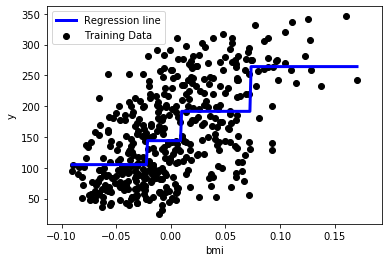

In [63]:
# plt.scatter(diabetes_X.iloc[sort_idx],diabetes_Y.iloc[sort_idx],c = 'lightgray', label ='Training Data')

plt.scatter(diabetes_X.iloc[sort_idx],diabetes_Y.iloc[sort_idx],c='black', label='Training Data')
plt.plot(diabetes_X.iloc[sort_idx], tr.predict(diabetes_X.iloc[sort_idx]), c='blue', linewidth=3, label='Regression line')
# , c = 'red', label = 'Tree, $R^2 = %.2f$' %r2_score(diabetes_Y, tr.predict(diabetes_X[sort_idx])))
plt.xlabel('bmi')
plt.ylabel('y')
plt.legend()
plt.show()

### 4) 평가하기

In [64]:
print('R2 score: %.2f' % r2_score(diabetes_Y, tr.predict(diabetes_X)))

R2 score: 0.37
